In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import os
import polars as pl

# 市场规律统计

In [33]:
def structure_stats(fret, *states):
    state_frets = []
    counts = []; wgts = []; winrates = []; odds = []; kelly = []; avgrets = []; avgstds = []; avgsps = []
    for state in states:
        state_frets.append(eval("fret[state]"))
    for sf in state_frets:
        counts.append(len(sf))
        wgts.append('{:.2%}'.format(len(sf)/len(fret)))
        avgrets.append('{:.4%}'.format(sf.mean()))
        if sf.mean()>0:
            odd = -sf[sf>0].mean()/sf[sf<0].mean()
            winr = (sf>0).mean()
        else:
            odd = -sf[sf<0].mean()/sf[sf>0].mean()
            winr = (sf<0).mean()
        winrates.append('{:.2%}'.format(winr))
        odds.append('{:.4f}'.format(odd))
        kelly.append('{:.4f}'.format(winr*odd-(1-winr)))
        avgstds.append('{:.2%}'.format(sf.std()))
        avgsps.append('{:.2f}'.format(np.abs(sf.mean()/sf.std())))
    print(pd.DataFrame({'count': counts, 'wgt': wgts, 'avgret': avgrets, 'avgstd': avgstds, 'winr': winrates, 'odd': odds, 'kelly': kelly, 'avg sp': avgsps}, index=np.arange(1, len(states)+1)))

def annual_stat(fret, state):
    df = pd.DataFrame({'fret': fret[state]})
    ann_num = pd.DataFrame({'fret': fret, 'year': fret.index.str[:4]}).groupby('year')['fret'].count()
    df['year'] = df.index.str[:4]
    group = df.groupby('year')['fret']
    count = group.count()
    wgt = count / ann_num
    avgret = group.mean()
    avgstd = group.std()
    if df['fret'].mean()>0:
        winr = group.apply(lambda x: (x>0).mean())
        odd = group.apply(lambda x: -x[x>0].mean()/x[x<0].mean())
    else:
        winr = group.apply(lambda x: (x<0).mean())
        odd = group.apply(lambda x: -x[x<0].mean()/x[x>0].mean())
    kelly = winr*odd - (1-winr)
    avgsp = avgret/avgstd
    wgt = wgt.map(lambda x: '{:.2%}'.format(x))
    avgret = avgret.map(lambda x: '{:.4%}'.format(x))
    avgstd = avgstd.map(lambda x: '{:.2%}'.format(x))
    winr = winr.map(lambda x: '{:.2%}'.format(x))
    odd = odd.map(lambda x: '{:.4f}'.format(x))
    kelly = kelly.map(lambda x: '{:.2f}'.format(x))
    avgsp = avgsp.map(lambda x: '{:.2f}'.format(x))
    print(pd.DataFrame({'count': count, 'wgt': wgt, 'avgret': avgret, 'avgstd': avgstd, 'winr': winr, 'odd': odd, 'kelly': kelly, 'avg sp': avgsp}))

In [ ]:
df = pd.read_pickle('./data/hsi.pkl')
df = df.loc[(df.index<='20230531')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
vs = df['volume'].rolling(5).std()
f1 = vs.rolling(5).rank()
state1 = f1==4
structure_stats(fret, *(state1,))
# annual_stat(fret, state3)
# annual_stat(fret, state4)

In [738]:
# df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<=pd.to_datetime('20230630'))&(df.index>=pd.to_datetime('20180101'))]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
# pmax = df['high'].rolling(2).max()
# pmin = df['low'].rolling(2).min()
# f1 = pmax.rolling(3).std()-pmin.rolling(3).std()
# f2 = df['volume'].rolling(5).skew()
# f3 = (df['close']-df['low'])/(df['high']-df['low'])
f1 = df['retsk']
state1 = (f1<0)
# state3 = (~state1)&(~state2)&(f3<=3)&(f4<=-1)
structure_stats(fret, *(state1,))
# annual_stat(fret, state2)

   count     wgt   avgret avgstd    winr     odd   kelly avg sp
1    518  38.86%  0.0269%  1.47%  53.67%  0.9082  0.0241   0.02


In [736]:
import polars as pl
df = pl.read_parquet('./mbar/zz1000.parquet').group_by('date_id').agg(
    [
        pl.col('close').last().cast(pl.Float64),
        pl.col('open').first().cast(pl.Float64),
        pl.col('high').max().cast(pl.Float64),
        pl.col('low').min().cast(pl.Float64),
        pl.col('volume').cast(pl.Int64).sum(),
        pl.col('amount').sum().cast(pl.Float64),
        pl.col('close').cast(pl.Float64).pct_change().skew().alias('retsk')
     ]
).sort('date_id').to_pandas().set_index('date_id')


In [64]:
df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<='20230731')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
# mid = 0.5*(df['open']+df['close'])
m1 = (df['high']-np.maximum(df['close'], df['open']))
m2 = (np.minimum(df['close'], df['open'])-df['low'])
f1 = m1-m2
state1 = f1>0
structure_stats(fret, *(state1, ))
annual_stat(fret, state1)

   count     wgt   avgret avgstd    winr     odd   kelly avg sp
1    564  41.65%  0.1558%  1.58%  56.21%  1.0092  0.1293   0.10
      count     wgt    avgret avgstd    winr     odd  kelly avg sp
year                                                              
2018    109  44.86%  -0.3346%  1.49%  43.12%  0.7232  -0.26  -0.23
2019    105  43.03%   0.1718%  1.74%  54.29%  1.0857   0.13   0.10
2020     92  37.86%   0.3741%  2.08%  65.22%  0.8603   0.21   0.18
2021     93  38.27%   0.3065%  1.18%  56.99%  1.4445   0.39   0.26
2022    107  44.21%   0.3130%  1.54%  62.62%  1.0140   0.26   0.20
2023     57  41.61%   0.1711%  0.83%  56.90%  1.2489   0.28   0.21


In [200]:
# pd.read_feather('./dump/etftiming1.feather')
pd.read_pickle('./dump/stocktiming1.pkl')

code,000004.SZ,000005.SZ,600602.SH,600601.SH,600656.SH,600654.SH,600651.SH,600653.SH,600652.SH,000002.SZ,...,301595.SZ,001390.SZ,603049.SH,301590.SZ,920027.BJ,688775.SH,603382.SH,301678.SZ,603400.SH,920037.BJ
trade_date,,,,,,,,,,,,,,,,,,,,,
20170710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250624,-0.474755,NaN,-0.584570,0.135074,NaN,-0.363750,-0.348794,-0.162767,NaN,-0.009284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250625,-0.431556,NaN,-0.407288,-0.196433,NaN,-0.282050,-0.398506,-0.136263,NaN,0.018696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250626,-0.522860,NaN,-0.243587,-0.496210,NaN,-0.254694,-0.383261,-0.122423,NaN,0.044685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 不同策略对比

## 1.1 因子/策略相关性测试

In [13]:
from datetime import datetime
check_id = 'timing1_v1'
compare = []
pnl0 = pd.read_pickle(f'./pnl/{check_id}.pnl.pkl')['pnl']
pnl0.name = check_id
compare.append(pnl0)
for pnl_id in os.listdir('./pnl'):
    if pnl_id.startswith('timing') and pnl_id[:-8] != check_id:
            pnl = pd.read_pickle(f'./pnl/{pnl_id}')['pnl']
            pnl.name = pnl_id[:-8]
            # print(f'{pnl_id[:-8]}: {pnl.corr(basic):.4)
            compare.append(pnl)
compare = pd.concat(compare, axis=1, join='inner')
compare = compare[pd.to_datetime(compare.index)<=datetime(2023, 7, 31)]
print(compare.drop(columns=[check_id]).corrwith(compare[check_id]))

timing1       0.887243
timing2       0.313279
timing2_v1    0.081265
timing4       0.361065
timing5       0.738021
timing6       0.195490
dtype: float64


In [10]:
pd.read_pickle('./pnl/timing2.pnl.pkl')
# compare

,pnl,dpos
trade_date,,
20250102,NaN,NaN
20250103,0.000000,0.0
20250106,-0.033689,1.0
20250107,-0.000549,0.0
20250108,0.009511,0.0
...,...,...
20250725,0.015698,2.0
20250728,-0.001198,2.0
20250729,-0.001564,0.0


## 1.2 策略曲线对比

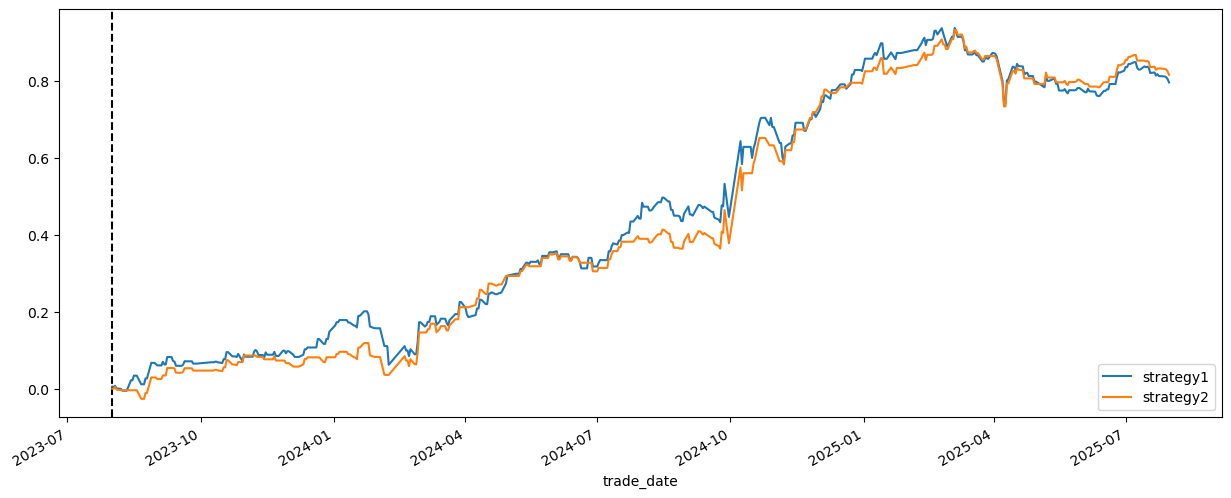

In [24]:
nav1 = pd.read_pickle('./pnl/timing1.pnl.pkl')
nav1 = nav1.loc[nav1.index>='20230801', 'pnl'].cumsum()
nav1.index = pd.to_datetime(nav1.index)
nav2 = pd.read_pickle('./pnl/timing1_v1.pnl.pkl')
nav2 = nav2.loc[nav2.index>='20230801', 'pnl'].cumsum()
nav2.index = pd.to_datetime(nav2.index)
# nav2 = nav2-nav1
ax = nav1.plot(label='strategy1', figsize=(15,6))
ax.axvline(pd.to_datetime('20230801'), color="black", linestyle="--")  # 添加分割线
ax.plot(nav2, label='strategy2')
ax.legend()

In [324]:
pd.read_pickle('./dump/stocktiming5.pkl')
# pd.read_pickle('./dump/timing5.pkl')

code,000004.SZ,000005.SZ,600653.SH,600652.SH,600602.SH,600601.SH,600656.SH,600654.SH,600651.SH,000002.SZ,...,603014.SH,001390.SZ,603049.SH,301590.SZ,920027.BJ,688775.SH,603382.SH,301678.SZ,603400.SH,920037.BJ
trade_date,,,,,,,,,,,,,,,,,,,,,
20170710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250624,-0.599572,NaN,0.106723,NaN,1.000000,-0.152706,NaN,0.706167,-0.256087,0.639798,...,-0.060490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250625,-0.600475,NaN,0.567901,NaN,1.000000,-0.576529,NaN,1.000000,-0.711119,0.955562,...,0.487126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250626,-1.000000,NaN,-0.742198,NaN,1.000000,-0.669626,NaN,1.000000,-0.773645,0.152322,...,-0.887045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.3 策略绩效回顾

In [250]:
def stats(pnl_pd: pd.DataFrame):
    pnl_pd.index = pd.to_datetime(pnl_pd.index)
    dateindex = pnl_pd.index
    pnl_pd['nav'] = pnl_pd['pnl'].cumsum()
    pnl_pd['year'] = pnl_pd.index.year.values
    # total
    ret = pnl_pd['pnl'].mean() * 250
    sp = pnl_pd['pnl'].mean() / pnl_pd['pnl'].std() * np.sqrt(250)
    pnl_pd['dd_T'] = pnl_pd['nav'].cummax() - pnl_pd['nav']
    mdd = pnl_pd['dd_T'].max()
    dd_end = pnl_pd['dd_T'].idxmax()
    dd_start = pnl_pd.loc[:dd_end, 'nav'].idxmax()
    winr = (pnl_pd['pnl']>0).mean()
    odd = -pnl_pd.loc[pnl_pd['pnl']>0, 'pnl'].mean() / pnl_pd.loc[pnl_pd['pnl']<0, 'pnl'].mean() 
    calmar = ret / mdd
    tvr = pnl_pd['dpos'].mean()*250

    # yearly
    gpnl = pnl_pd.groupby('year')
    pnl_pd['dd_y'] = gpnl['nav'].cummax() - pnl_pd['nav']
    ret_y = gpnl['pnl'].mean() * 250
    sp_y = gpnl['pnl'].mean() / gpnl['pnl'].std() * np.sqrt(250)
    mdd_y = gpnl['dd_y'].max()
    dd_end_y = gpnl['dd_y'].idxmax()
    dd_start_y = gpnl.apply(lambda x: x.loc[:dd_end_y[x['year'].values[0]], 'nav'].idxmax())
    winr_y = gpnl['pnl'].apply(lambda x: (x>0).mean())
    odd_y = -gpnl['pnl'].apply(lambda x: x[x>0].mean() / x[x<0].mean())
    calmar_y = ret_y / mdd_y
    tvr_y = gpnl['dpos'].mean() * 250

    index1 = gpnl.head(1).index
    index2 = gpnl.tail(1).index
    out = pd.DataFrame({'ret': ret_y.values*100,
                        'sp': sp_y.values,
                        'dd': mdd_y.values*100,
                        'dd_start': dd_start_y.values,
                        'dd_end': dd_end_y.values,
                        'anntvr': tvr_y.values,
                        'winr': winr_y.values*100,
                        'odd': odd_y.values,
                        'calmar': calmar_y.values}, index=pd.MultiIndex.from_arrays([index1, index2], names=['from', 'to']))
    out.loc[(dateindex[0], dateindex[-1]), :] = [ret*100, sp, mdd*100, dd_start, dd_end, tvr, winr*100, odd, calmar]
    print(out)

In [333]:
pnl1 = pd.read_pickle('./pnl/etftiming2.pnl.pkl')
pnl2 = pd.read_pickle('./pnl/etftiming3.pnl.pkl')
pnl = pd.DataFrame({'pnl': (pnl1['pnl']+pnl2['pnl'])/2, 'dpos': (pnl1['dpos']+pnl2['dpos'])/2})
pnl = pnl[pnl.index>=pd.to_datetime('20230701')]
stats(pnl)

                             ret        sp        dd   dd_start     dd_end  \
from       to                                                                
2023-07-03 2023-12-29  11.302419  2.751312  1.244471 2023-09-04 2023-09-22   
2024-01-02 2024-12-31   6.537176  0.989445  5.660514 2024-08-19 2024-10-08   
2025-01-02 2025-06-30  25.864712  4.330274  1.483311 2025-03-06 2025-03-12   
2023-07-03 2025-06-30  12.442377  2.104212  5.660514 2024-08-19 2024-10-08   

                           anntvr       winr       odd     calmar  
from       to                                                      
2023-07-03 2023-12-29  211.815937  55.645161  1.273018   9.082104  
2024-01-02 2024-12-31  238.116218  59.504132  0.819545   1.154873  
2025-01-02 2025-06-30  228.364845  62.393162  1.397172  17.437146  
2023-07-03 2025-06-30  229.002045  59.213251  1.022927   2.198100  


C:\Users\User\AppData\Local\Temp\ipykernel_30232\1405865654.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_start_y = gpnl.apply(lambda x: x.loc[:dd_end_y[x['year'].values[0]], 'nav'].idxmax())


# 交易对胜率提升

In [ ]:
# df = pd.read_pickle('./data/[v2交易对stk]无强制闭环_20241207.pkl')
# df = df[df.factor_date>=pd.to_datetime('20200101')].reset_index(drop=True)

alpha = pd.read_pickle('./dump/alpha5_v1.pkl')
alpha.index = pd.to_datetime(alpha.index)
alpha = alpha.rank(axis=1, method='dense', pct=True)
alpha_ts = alpha.stack().reset_index()
alpha_ts.columns = ['factor_date', 'code', 'alpha']

df1 = df.merge(alpha_ts, on=['code', 'factor_date'], how='left')
# low = (df1.loc[df1['alpha']<0.33, 'return']>0).mean()
low = len(df1.loc[df1['alpha']<0.33, 'return'])/len(df1)
# med = (df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return']>0).mean()
med = len(df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return'])/len(df1)
# high = (df1.loc[df1['alpha']>=0.67, 'return']>0).mean()
high = len(df1.loc[df1['alpha']>=0.67, 'return'])/len(df1)
# print(low, med, high)

df1['year'] = df1['factor_date'].dt.year
gpdf = df1.groupby('year')[['alpha', 'return']]
# glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
glow = gpdf.apply(lambda x: len(x.loc[x['alpha']<0.33, 'return'])/len(x))
# gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
gmed = gpdf.apply(lambda x: len(x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return'])/len(x))
# ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
ghigh = gpdf.apply(lambda x: len(x.loc[x['alpha']>=0.67, 'return'])/len(x))
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

In [ ]:
df = pd.read_feather('./dump/hfetf.feather')
gdf = df.groupby('datetime')
print(f"平均每小时信号量: {gdf['dpos'].apply(lambda x: (x.abs()>0).sum()).mean()}")
print(f"平均单笔收益: {(gdf['pnl'].sum()/gdf['dpos'].apply(lambda x: (x.abs()>0).sum())).mean()}")
print(f"平均胜率: {(df['pnl']>0).mean()}")
print(f"平均盈亏比: {-(df['pnl'][df['pnl']>0]).mean()/(df['pnl'][df['pnl']<0]).mean()}")

In [18]:
df=pd.read_feather('./dump/hfetf.feather')
# M = 5
# bins = np.linspace(-1, 1, 2*M+2)
# labels = np.linspace(-1, 1, 2*M+1)
# df['pos'] = df.groupby('code')['factor'].transform(lambda col: pd.cut(col.rolling(60).rank(pct=True), bins=bins, labels=labels).astype(float))

In [28]:
df = pd.read_excel('../策略/ETF T0/活跃ETF池.xlsx')
df['代码'] = df['代码'].astype(str)
df.loc[df['代码'].str.startswith('5'), '代码'] = df['代码']+'.SH'
df.loc[df['代码'].str.startswith('1'), '代码'] = df['代码']+'.SZ'
df = df[df['市场'].notna()]
df['代码'].to_csv('./derivative_data/activeetf.csv')

In [247]:
df1 = pd.DataFrame(np.random.randint(0, 2, (10, 20)))
df2 = pd.DataFrame(np.random.choice([True, False], (10, 20)))
df1&df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,True
1,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
2,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False
3,True,False,False,False,False,False,True,True,False,True,True,False,False,False,True,True,False,False,True,False
4,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,False,False,False,False,False
5,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False
6,False,True,True,False,False,True,False,False,True,True,True,True,True,False,False,True,False,False,False,True
7,False,True,False,True,False,True,False,False,False,False,False,True,True,False,False,False,False,True,True,False
8,False,False,False,True,False,True,True,False,True,True,False,False,True,False,True,False,True,False,False,False
9,True,False,False,True,False,True,True,True,True,True,True,False,False,False,False,False,False,True,True,False


In [248]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0
2,1,0,0,1,0,1,0,0,0,1,1,0,1,1,0,1,0,1,1,0
3,1,0,1,0,1,1,1,1,0,1,1,1,0,0,1,1,0,0,1,0
4,0,0,0,1,1,0,1,0,0,0,1,0,1,1,1,0,0,1,0,1
5,0,0,1,0,0,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0
6,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1
7,1,1,0,1,1,1,0,1,1,1,0,1,1,0,1,0,0,1,1,1
8,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0
9,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,0
